# Chapter 4 - Time Series Features

$$
F_T=max(0, 1 − \frac{Var(R_t)}{Var(T_t+R_t)}).\\
F_S=max(0, 1 − \frac{Var(R_t)}{Var(S_t+R_t)}).
$$

A series with seasonal strength $F_S$ close to 0 exhibits almost no seasonality, while a series with strong seasonality will have  
$F_S$ close to 1 because $Var(R_t)$ will be much smaller than $Var(S_t+R_t)$.

In [348]:
from tsdata.raw import available_data, load_data
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


import numpy as np
# plotting
from plotnine import (ggplot, geom_line, xlab, ylab, ggtitle, aes, theme, 
                     geom_density, geom_histogram, after_stat, geom_ribbon,
                      facet_wrap,  geom_point, scale_color_manual, scale_alpha_manual)


In [349]:
from statsmodels.base.transform import BoxCox
from statsmodels.tsa.seasonal import seasonal_decompose

aus_production_df = load_data("aus_production").assign(
    Date=lambda df: pd.to_datetime(df.Quarter.str.replace(" ", "-"))
)

last_aus_prod = aus_production_df.set_index('Date').tail(5*4)

In [350]:

last_aus_prod.Y = np.repeat(100, last_aus_prod.shape[0])

def _strength(ts, period, var_ratio, model='additive'):
    decomposition = seasonal_decompose(
        x=ts,
        period=period,
        model=model
    )
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    resid = decomposition.resid

    var_ratio = var_ratio(trend, seasonal, resid)
    strength = np.max(np.array([0, 1]) - var_ratio)
    return 0 if np.isnan(strength) else strength


def trend_strength(ts, period=4, model='additive'):
    return _strength(
        ts,
        period=4,
        var_ratio=lambda t, _, r: np.nan_to_num(r).var() / np.nan_to_num(r + t).var(),
        model=model
    )

def season_strength(ts, period=4, model='additive'):
    return _strength(
        ts,
        period=period,
        var_ratio=lambda _, s, r: np.nanvar(r) / np.nanvar(r + s),
        model=model
    )


seasonal_decompose(
    x=last_aus_prod.Beer,
    model='additive',
    period=4
    
)
# last_aus_prod.Beer.plot()
season_strength(
    last_aus_prod.Beer,
    period=4
)

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_3598/2111273942.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


0.9759454231167615

We can then use these features in plots to identify what type of series are heavily trended and what are most seasonal.

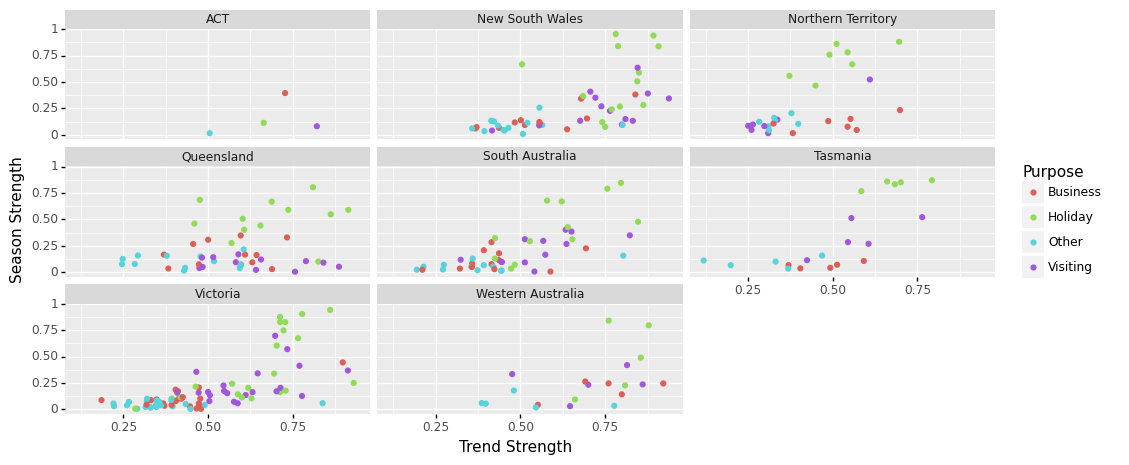

<ggplot: (8784908722490)>

In [351]:
# TODO: write this in a function

tourism_df = load_data('tourism').assign(
    Date=lambda df: pd.to_datetime(
        df.Quarter.str.replace(" ", "-"))
    ).set_index('Date')

grouped = tourism_df.groupby(['Region', 'State', 'Purpose'])

trend_strengths = grouped.apply(lambda df: trend_strength(df.Trips,)).rename("trend_strength")
season_strengths = grouped.apply(lambda df: season_strength(df.Trips)).rename("season_strength")

trend_strengths.reset_index()

(pd.concat([
    trend_strengths, season_strengths
], axis=1)
.reset_index()
.pipe(ggplot) +
    aes(x='trend_strength', y='season_strength', color='Purpose') +
    geom_point() +
    facet_wrap('State') +
    xlab("Trend Strength") +
    ylab("Season Strength") +
    theme(figure_size=[12, 5])
)


# .apply(lambda df: season_strength(df.Trips))


We can see that holiday series are most seasonal.

In [352]:
tourism_df.head()

,Quarter,Region,State,Purpose,Trips
Date,,,,,
1998-01-01,1998 Q1,Adelaide,South Australia,Business,135.077690
1998-04-01,1998 Q2,Adelaide,South Australia,Business,109.987316
1998-07-01,1998 Q3,Adelaide,South Australia,Business,166.034687
1998-10-01,1998 Q4,Adelaide,South Australia,Business,127.160464
1999-01-01,1999 Q1,Adelaide,South Australia,Business,137.448533


# Chapter 5

In [353]:
# 1. load the data and preprocess
global_economy_df = load_data("global_economy").assign(gdp_per_capita = lambda df: df.GDP / df.Population)
 
global_economy_df.head()

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population,gdp_per_capita
0,Afghanistan,AFG,1960,5.377778e+08,NaN,NaN,7.024793,4.132233,8996351.0,59.777327
1,Afghanistan,AFG,1961,5.488889e+08,NaN,NaN,8.097166,4.453443,9166764.0,59.878153
2,Afghanistan,AFG,1962,5.466667e+08,NaN,NaN,9.349593,4.878051,9345868.0,58.492874
3,Afghanistan,AFG,1963,7.511112e+08,NaN,NaN,16.863910,9.171601,9533954.0,78.782758
4,Afghanistan,AFG,1964,8.000000e+08,NaN,NaN,18.055555,8.888893,9731361.0,82.208444


<AxesSubplot:xlabel='Year'>

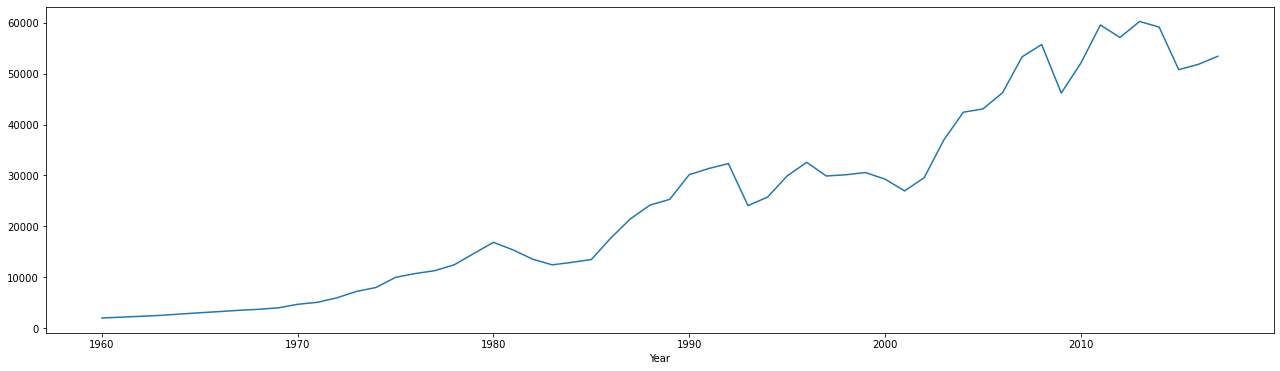

In [354]:
# 2. visualize
global_economy_df[global_economy_df.Country == 'Sweden'].set_index('Year').gdp_per_capita.plot()

In [355]:
# 3. define a model
# 4. Train a model
# 5. Check model performance
# 6. Produce forecasts

## Some simple forecasting methods
- Mean
- Naive Method $\hat{y}_{T+h|T} = y_T$ (good for starting the series and there is not enough data)
- Seasonal Naive $\hat{y}_{T+h|T} = y_{T+h-m(k+1)}$ where  $m = $ the seasonal period, and k is the integer part of $(h−1)/m$ - Not good when the divergence of seasonality changes

- Drift method

The simple methods
- Might be the best method we have
- Can be used only as a benchmark to try to beat from a more complicated model

## Fitted Values $\hat{y}$

## Residuals diagnostics

- Innovation residuals are those residuals given after the transformation

A good forecasting method will yield innovation residuals with the following properties:

- The innovation residuals are uncorrelated. If there are correlations between innovation residuals, then there is information left in the residuals which should be used in computing forecasts.
- The innovation residuals have zero mean. If they have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties.

- The innovation residuals have constant variance. This is known as “homoscedasticity”.
- The innovation residuals are normally distributed.

### Example: Forecasting Google daily closing stock prices


In [356]:
# For stock market prices and indexes, the best forecasting method is often the naïve method. That is, each forecast is simply equal to the last observed value, 
gafa_stock_df = (load_data("gafa_stock")
 .assign(Date=lambda df: pd.to_datetime(df.Date))
#  .set_index('Date')
)

is_google = gafa_stock_df.Symbol == "GOOG"
is_2015 = gafa_stock_df.Date.dt.year == 2015

# take only 2015s google stock prices
google_stock_2015_df = gafa_stock_df[is_google & is_2015]

google_stock_2015_df.head()

,Symbol,Date,Open,High,Low,Close,Adj_Close,Volume
4026,GOOG,2015-01-02,526.114746,528.362366,521.231628,521.937744,521.937744,1447600
4027,GOOG,2015-01-05,520.396240,521.460388,510.252045,511.057617,511.057617,2059800
4028,GOOG,2015-01-06,512.181458,513.350037,498.307800,499.212799,499.212799,2899900
4029,GOOG,2015-01-07,504.225220,504.467896,496.915436,498.357513,498.357513,2065100
4030,GOOG,2015-01-08,495.264526,500.724487,488.312805,499.928864,499.928864,3353600


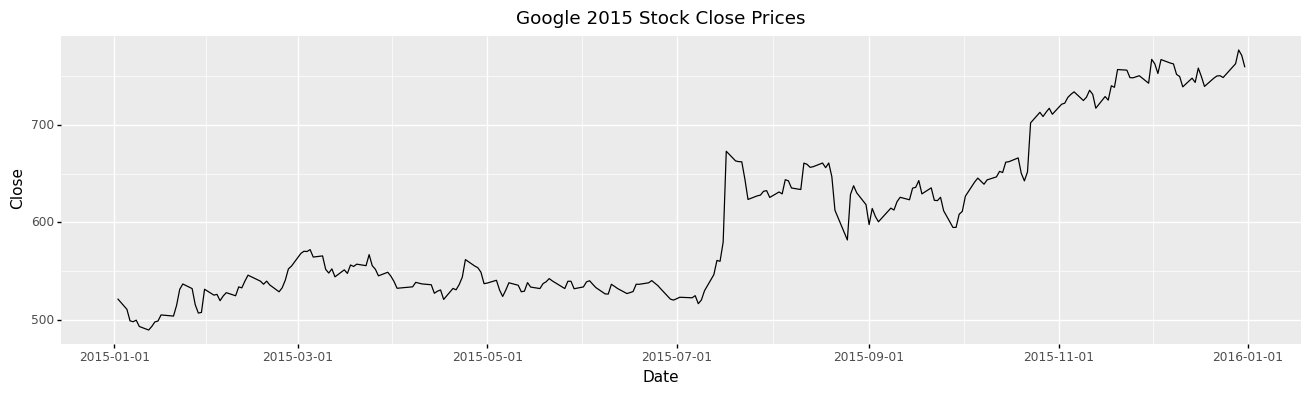

<ggplot: (8784884495345)>

In [357]:
google_stock_2015_close = google_stock_2015_df.set_index('Date').Close

(ggplot(google_stock_2015_df) +
    aes(x='Date', y='Close') +
    geom_line() +
    # geom_point() +
    theme(figure_size=[16, 4]) +
    ggtitle('Google 2015 Stock Close Prices')
)

A good model for stock prices is just using the last value (Naive model)

In [2]:
google_stock_2015_close.head(3)

NameError: name 'google_stock_2015_close' is not defined

<AxesSubplot:title={'center':'Naive Forecast Residuals'}, xlabel='Date'>

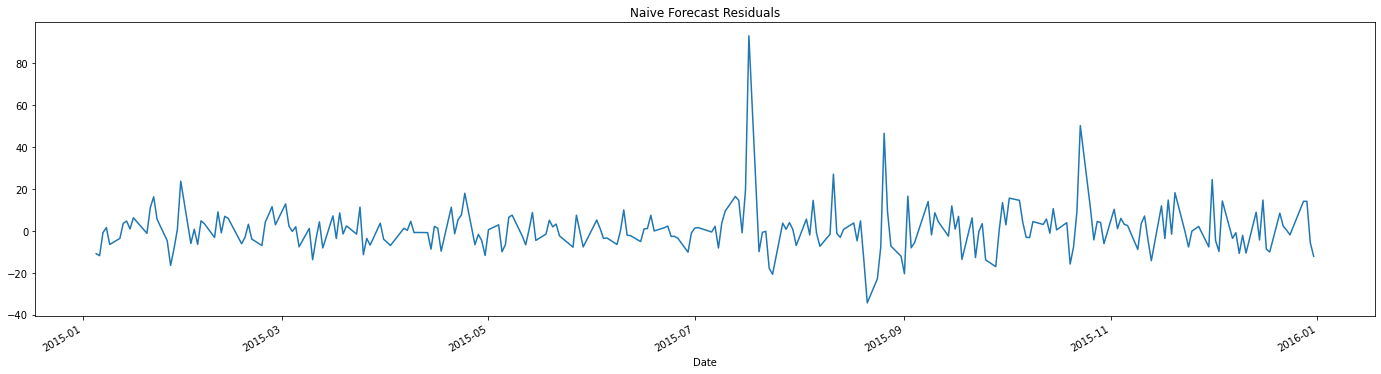

In [359]:

google_2015_close_residuals =  google_stock_2015_close - google_stock_2015_close.shift()
google_2015_close_residuals.plot(figsize=(24, 6), title='Naive Forecast Residuals')

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 42'. Pick better value with 'binwidth'.


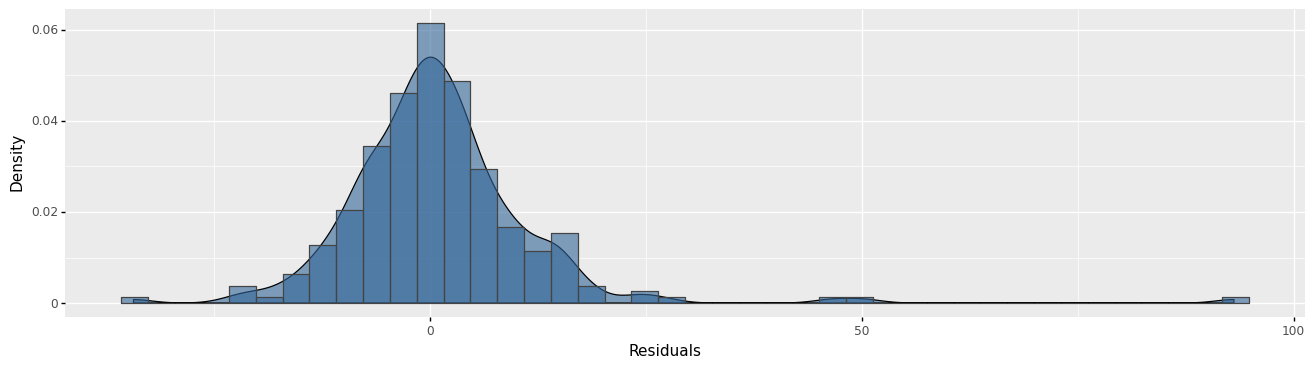

<ggplot: (8784881635503)>

In [360]:
(google_2015_close_residuals[1:]
 .reset_index()
 .pipe(ggplot) +
    aes(x='Close', y=after_stat('density')) +
    geom_density(fill='#336699', alpha=0.6) +
    geom_histogram(alpha=0.6, fill='#336699', color='#444') +
    xlab("Residuals") +
    ylab('Density') +
    theme(figure_size=(16, 4))
)

 Consequently, forecasts from this method will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.


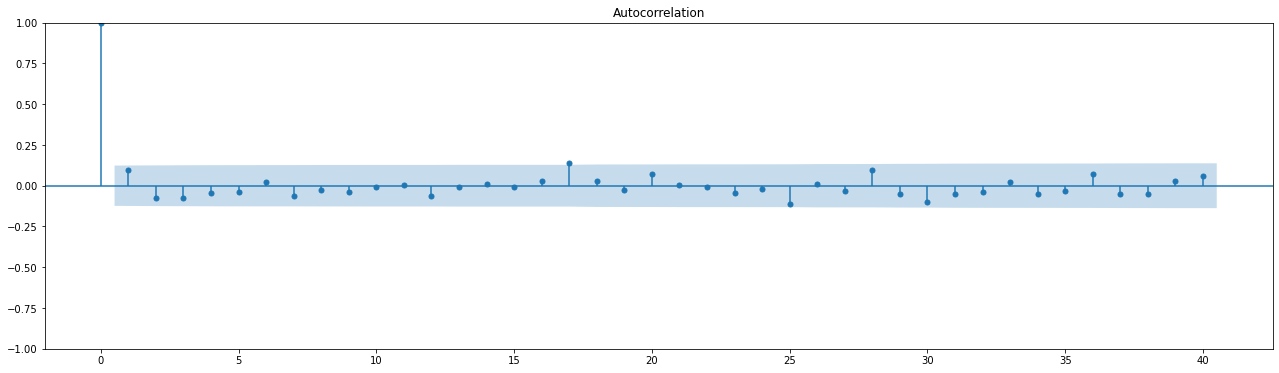

In [361]:
import statsmodels.api as sm

plt.rc("figure", figsize=(22, 6))
fig = sm.graphics.tsa.plot_acf(google_2015_close_residuals[1:], lags=40)
plt.show()


 Consequently, forecasts from this method will probably be quite good, but prediction intervals that are computed assuming a normal distribution may be inaccurate.

 ### Portmanteau tests for autocorrelation

 In order to overcome this problem, we test whether the first $\mathfrak{L}$ autocorrelations are significantly different from what would be expected from a white noise process. A test for a group of autocorrelations is called a portmanteau test, from a French word describing a suitcase or coat rack carrying several items of clothing.

 One such test is the Box-Pierce test, based on the following statistic

 $$
 Q=T\sum_{k=1}^{\mathfrak{L}}{r_k^2}
 $$

 where $\mathfrak{L}$ is the maximum lag considered and T is the number of observations. We suggest using $\mathfrak{L}=10$ for non-seasonal data and  
$\mathfrak{L}=2m$ for seasonal data, where m is the period of seasonality. However, the test is not good when 
$\mathfrak{L}$ is large, so if these values are larger than   T / 5  , then use  = T / 5
 

 A related (and more accurate) test is the Ljung-Box test, based on 
 
 $$
 Q^* = T ( T + 2 ) \sum_{k = 1}^{\mathfrak{L}}{( T − k )^{−1} r_k^2}
 $$

How large is too large? If the autocorrelations did come from a white noise series, then both Q and $Q^∗$   would have a   $χ^2$ distribution with(ℓ − K) degrees of freedom, where K is the number of parameters in the model. If they are calculated from raw data (rather than the residuals from a model), then set K = 0.

In [362]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

acorr_ljungbox(google_2015_close_residuals[1:], lags=[10], return_df=True, boxpierce=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
10,7.914143,0.637223,7.744517,0.653776


The p-values are high, thus, we can conclude that the residuals are not distinguishable from a white noise series.

Question: How to do the Random Walk model?

In [336]:
T = google_stock_2015_close.shape[0]
sd = np.sqrt((google_2015_close_residuals**2/T).sum())

# 95% confidence interval for a t+1 prediction
ci_95 = google_stock_2015_close[-1] + np.array([-1.96, 1.96]) * sd
ci_95

array([736.99198007, 780.76802993])

In [337]:
import datetime

last_date = google_stock_2015_df.Date.iloc[-1]

forecast_x = [last_date + datetime.timedelta(days=n_days) for n_days in range(1, 11)]

h = np.arange(1, 11)
sd_h = sd * np.sqrt(h)

# # 90% confidence intervals
forecast_mean = np.repeat(google_stock_2015_close[-1], 10)
forecast_lwr = forecast_mean - 1.96 * sd_h
forecast_upr = forecast_mean + 1.96 * sd_h


# 80% confidence intervals
forecast_lwr_80 = forecast_mean - 1.28 * sd_h
forecast_upr_80 = forecast_mean + 1.28 * sd_h

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_3598/3466786583.py:10: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


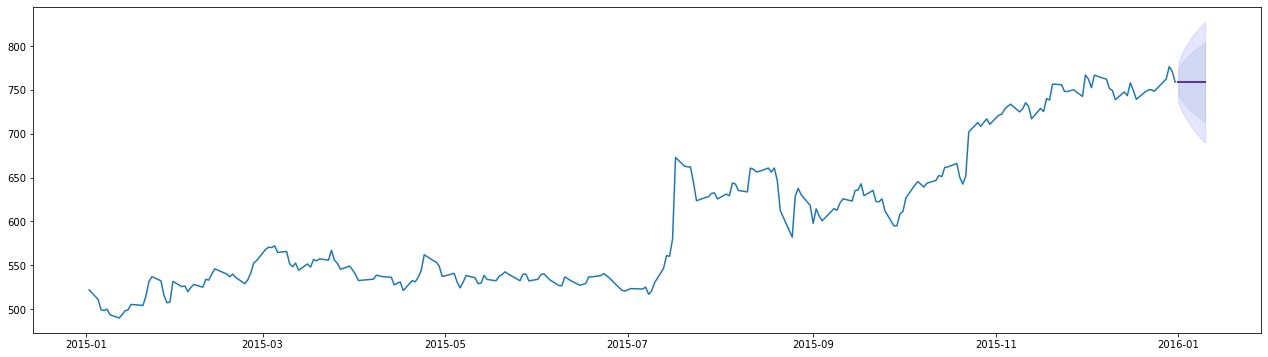

In [338]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# plot the close date for the dates we have
ax.plot(google_stock_2015_df.Date, google_stock_2015_df.Close)

# plot the forecast with the additional prediction intervals
ax.plot(forecast_x, forecast_mean, 'k-', lw=2, color='#553999')

ax.fill_between(forecast_x, forecast_lwr, forecast_upr, color='b', alpha=.1)
ax.fill_between(forecast_x, forecast_lwr_80, forecast_upr_80, color='#336699', alpha=.1)

When a normal distribution for the residuals is an unreasonable assumption, one alternative is to use bootstrapping, which only assumes that the residuals are uncorrelated with constant variance.

Assuming future errors will be similar to past errors, we can replace  $e_{T+1}$ by sampling from the collection of errors we have seen in the past (i.e., the residuals). Adding the new simulated observation to our data set, we can repeat the process to obtain

$$
y_{T + 2} = \hat{y}_{T + 2| T + 1} + e_{T + 2}
$$

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_3598/1196425768.py:28: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


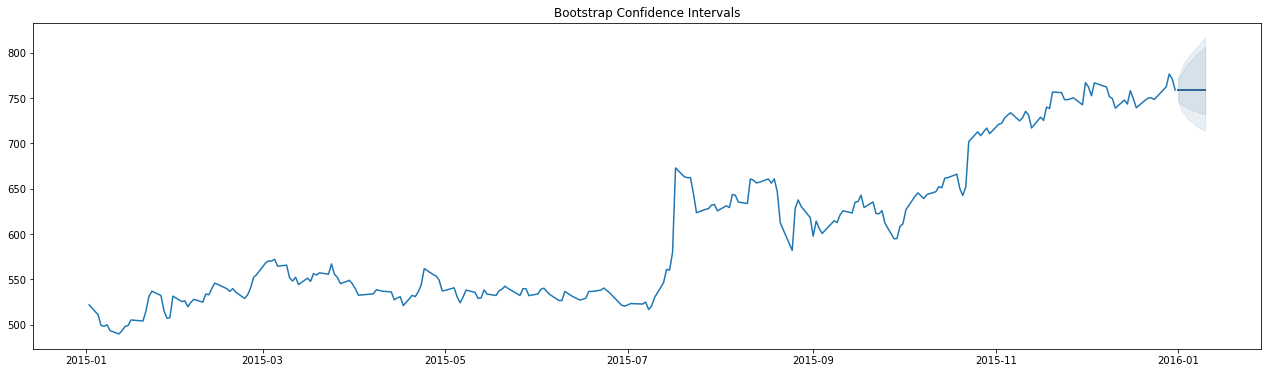

In [339]:
# get resamples from the residuals so far

forecast = google_stock_2015_close[-1]


# instead of trajectorize we can also use fitted_model.simulate(8, repetitions=100)
def trajectorize(residuals, forecast, h=10):
    residuals_sample = np.random.choice(residuals[1:], size=10)
    return forecast + np.cumsum(residuals_sample)

fig, ax = plt.subplots()
ax.plot(google_stock_2015_df.Date, google_stock_2015_df.Close)
ax.set_title("Bootstrap Confidence Intervals")

# generate many 1e4 different trajectories
N = int(1e4)
bs_residuals = google_2015_close_residuals.tail(10)
paths = [trajectorize(bs_residuals, forecast) for _ in range(N)]
paths = np.array(paths)

# compute 95% lower and upper ranges
lower = np.apply_along_axis(lambda x: np.quantile(x, 0.025), 0, paths)
upper = np.apply_along_axis(lambda x: np.quantile(x, 0.95), 0, paths)

# compute 80% lower and upper ranges
lower_80 = np.apply_along_axis(lambda x: np.quantile(x, 0.10), 0, paths)
upper_80 = np.apply_along_axis(lambda x: np.quantile(x, 0.90), 0, paths)

# plot the forecast and the data
ax.plot(forecast_x, forecast_mean, 'k-', lw=2, color='#336699')

# plot 95% and 80% confidence interval
ax.fill_between(forecast_x, lower, upper, color='#336699', alpha=.1)
ax.fill_between(forecast_x, lower_80, upper_80, color='#336699', alpha=.1)

When forecasting decomposition data, we forecast the season and the non-season separately.

In [340]:
def add_naive_seasonal(series, forecast):
    # Naive Seasonal method assumes seasonality range doesnt change
    stl_decomposition = STL(series, seasonal=13).fit()

    last_months = stl_decomposition.seasonal.tail(12)
    last_months.index = last_months.index.month
    last_months_values = last_months.loc[forecast.index.month].values

    return forecast.add(last_months_values, fill_value=0)


/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


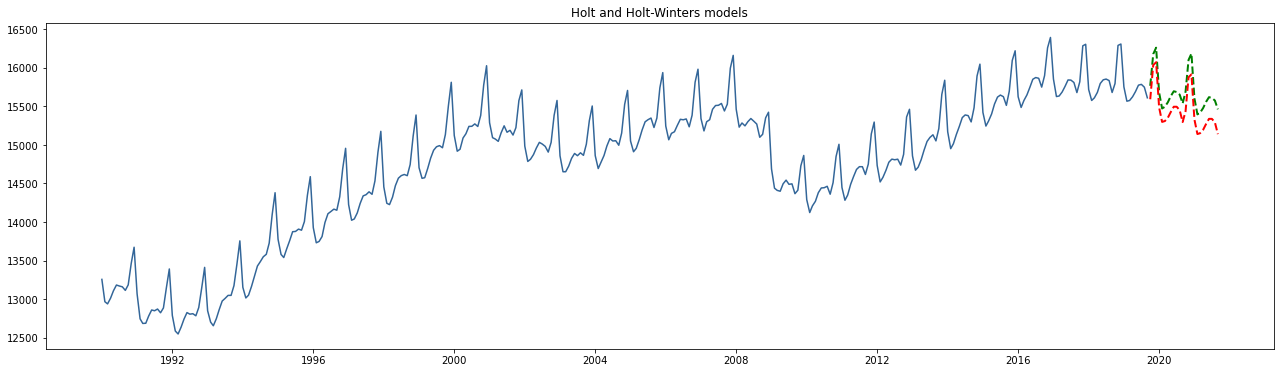

In [341]:
from statsmodels.tsa.api import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

us_employment_df = load_data("us_employment").assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y %b")
).assign(
    Year=lambda df: df.Date.dt.year,
    Month=lambda df: df.Date.dt.month
)

is_retail =  us_employment_df.Title == "Retail Trade"
is_after_1990 = us_employment_df.Year >= 1990

is_retail_after_1990 = is_retail & is_after_1990

# take only after 1990 retail
us_retail_employment_df = us_employment_df[is_retail_after_1990]
us_retail_employment_ts = us_retail_employment_df.set_index('Date').Employed

# Holt Exponential Smoothing Model
holt_fitted = Holt(us_retail_employment_ts).fit()

# Holt-Winters Exponential Smoothing Model
holt_winters_fitted = ExponentialSmoothing(
    us_retail_employment_ts,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated"
).fit()

# start up the plot
fig, ax = plt.subplots()
ax.plot(us_retail_employment_ts, color="#336699")
ax.set_title("Holt and Holt-Winters models")

# holt + naïve seasonal forecast
holt_forecast = holt_fitted.forecast(24)
holt_forecast = add_naive_seasonal(us_retail_employment_ts, holt_forecast)

# holt winters exponential smoothing forecast
holt_winters_forecast = holt_winters_fitted.forecast(24)

# plot the forecast and the data
ax.plot(holt_winters_forecast, '--', lw=2, color='green')
ax.plot(holt_forecast, '--', lw=2, color='red')

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_3598/1694984033.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


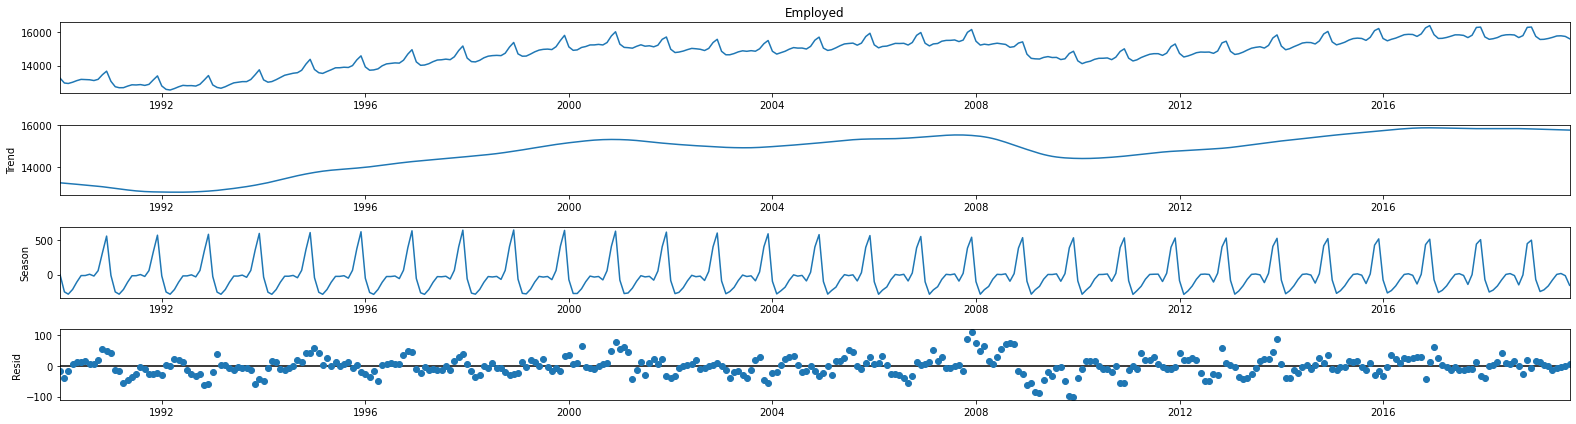

In [342]:
stl_plt = STL(us_retail_employment_ts, seasonal=13).fit().plot()
stl_plt.show()

### Explonential Smoothing

In [343]:
holt_winters_fitted = ExponentialSmoothing(
    us_retail_employment_ts,
    seasonal_periods=12,
    trend="add",
    seasonal="add",
    initialization_method="estimated"
).fit()

# 

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


The advantage of exponential smoothing methods over simple moving averages is that new data is depreciated at a constant rate, gradually declining in its impact, whereas the impact of a large or small value in a moving average, will have a constant impact. However, this also means that exponential smoothing methods are more sensitive to sudden large or small values.

The simple exponential smoothing method does not account for any trend or seasonal components, rather, it only uses the decreasing weights to forecast future results. This makes the method suitable only for time series without trend and seasonality.

<AxesSubplot:xlabel='Date'>

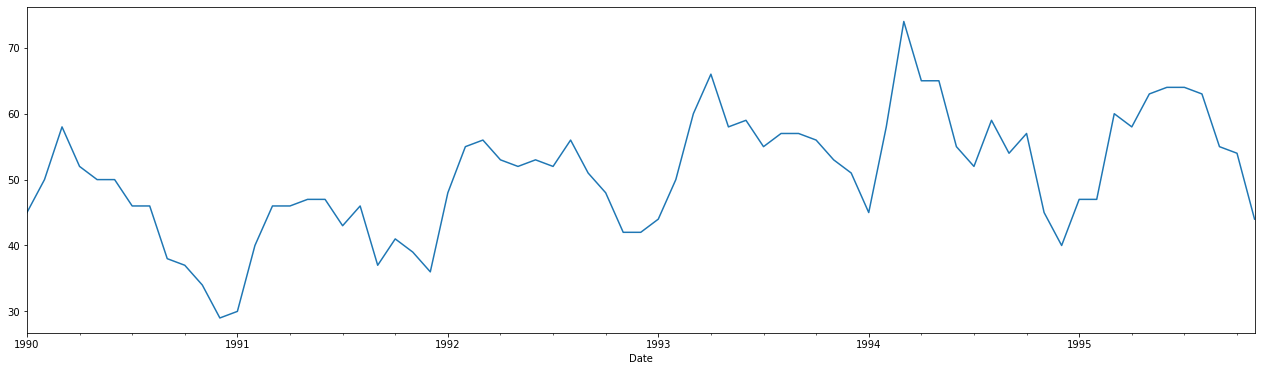

In [344]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

home_sales_ts = pd.read_excel(
    "./single-family-home-sales.xlsx", usecols="A,B"
).assign(
    Date=lambda df: pd.to_datetime(df.Month, format="%Y-%m")
).set_index('Date')['Home Sales']

home_sales_ts = home_sales_ts[:-1]

home_sales_ts.plot()


In [345]:
fitted_ses = SimpleExpSmoothing(
    home_sales_ts,
    initialization_method="heuristic"
).fit(smoothing_level=0.2, optimized=False)

fitted_ses.forecast(1)

fitted_ses.forecast()
# home_sales_ts.index

/usr/local/Caskroom/miniconda/base/envs/fpp/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.


1995-12-01    54.838027
Freq: MS, dtype: float64

### Holt's Linear Trend Method

<AxesSubplot:>

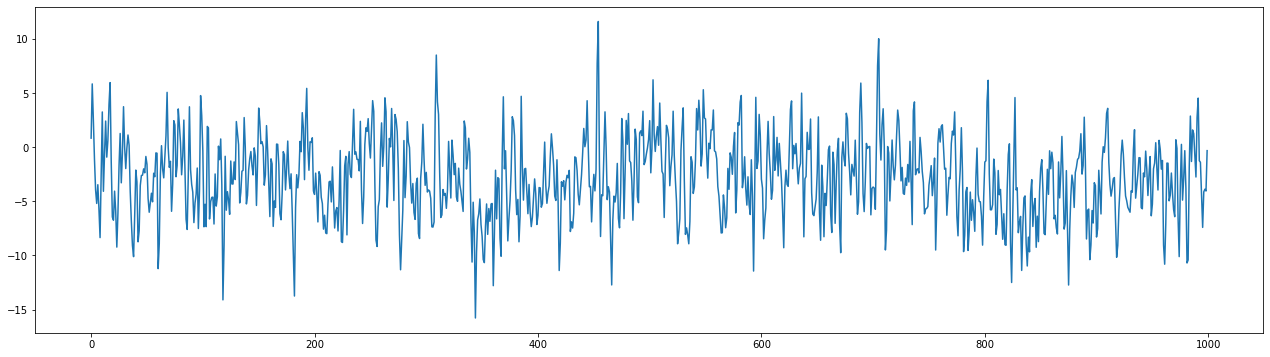

In [346]:
def lagelize(series):
    lag1 = series.shift()
    lag2 = lag1.shift()
    lag3 = lag2.shift()
    lag4 = lag3.shift()

    return lag1.multiply(0.5).add(lag2.multiply(0.25)).add(lag3.multiply(-0.75)).add(lag4.multiply(-0.05))


noise = pd.Series(np.random.normal(0, 4, 104))

lagelize(noise)

def generate_process():
    x = 0
    e0, e1, e2, e3 = np.random.normal(0, 4, 4)
    while True:
        x = x + 0.5 * e0 + 0.25 * e1 - 0.75 * e2 - 0.05 * e3
        e3 = e2
        e2 = e1
        e1 = e0
        e0 = np.random.normal(0, 4)
        yield x

generator = generate_process()

x = [next(generator) for _ in range(int(1e3))]
pd.Series(x).plot()

/var/folders/m5/zsd1m_dd4wd36c3_4bftzh280000gn/T/ipykernel_3598/1077422678.py:22: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.


Text(0.5, 1.0, 'Beer production + moving average')

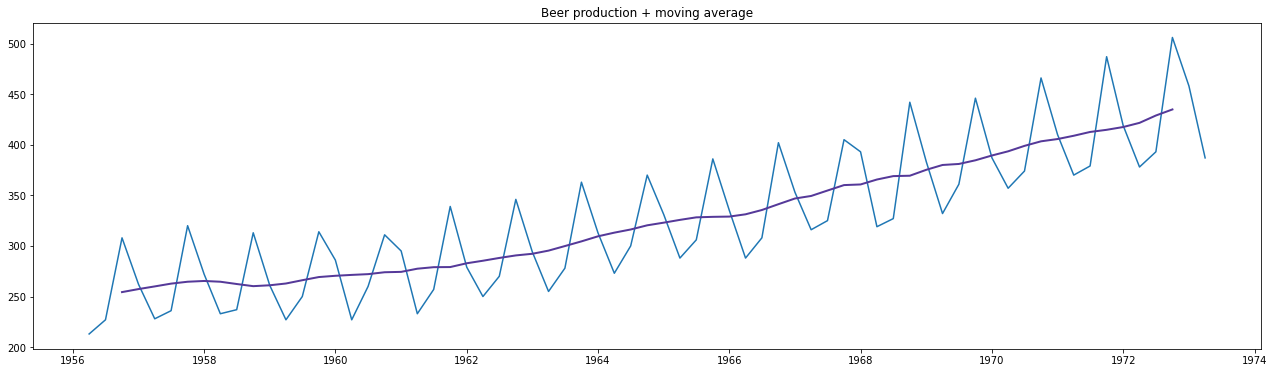

In [480]:
# aus_production_df
beer_ts = aus_production_df.set_index("Date").Beer[1:70]
# beer_ts.plot()
# N = 4
N = filtered_beer.shape[0]
filtered_beer = np.convolve(beer_ts, [1/8, 1/4, 1/4, 1/4, 1/8], mode='valid')
# filtered_beer.shape

# filtered_beer = np.insert(filtered_beer, 0, [np.nan, np.nan])
filtered_beer = np.append([np.nan, np.nan], filtered_beer)
filtered_beer = np.append(filtered_beer, [np.nan, np.nan])

filtered_beer
# filtered_beer.shape

filtered_beer_ts = pd.Series(filtered_beer, index=beer_ts.index)
filtered_beer_ts
# beer_ts.shape
fig, ax = plt.subplots()

ax.plot(beer_ts)
ax.plot(filtered_beer_ts, 'k-', lw=2, color='#553999')

ax.set_title("Beer production + moving average")


Text(0.5, 1.0, 'Seasonal Left Overs')

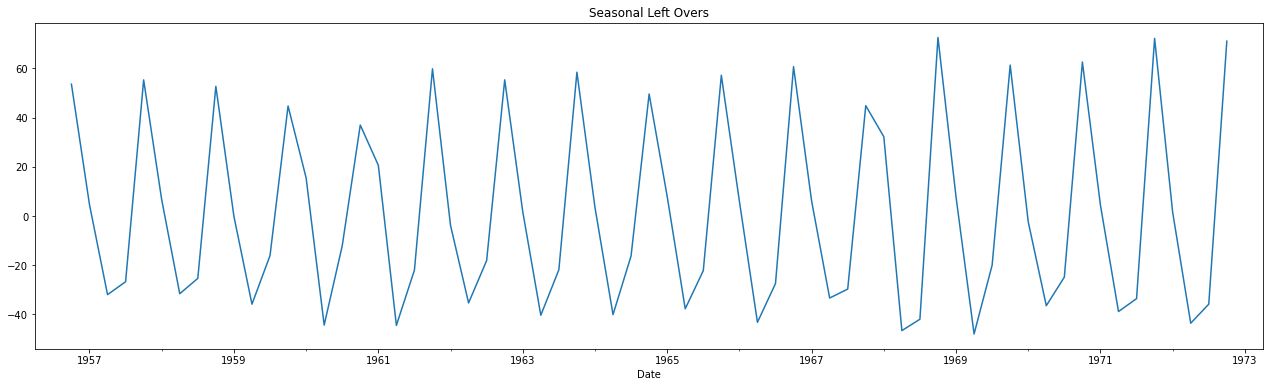

In [485]:
# get detrended values
seasonals_ts = (beer_ts - filtered_beer_ts)
seasonal_plot = seasonals_ts.plot()
seasonal_plot.set_title("Seasonal Left Overs")

Exercises:

In [487]:
# Write a function to compute the mean and standard deviation of a time series, and apply it to the PBS data.
# Plot the series with the highest mean, and the series with the lowest standard deviation.

load_data("PBS")

,Month,Concession,Type,ATC1,ATC1_desc,ATC2,ATC2_desc,Scripts,Cost
0,1991 Jul,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,18228,67877.0
1,1991 Aug,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15327,57011.0
2,1991 Sep,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14775,55020.0
3,1991 Oct,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,15380,57222.0
4,1991 Nov,Concessional,Co-payments,A,Alimentary tract and metabolism,A01,STOMATOLOGICAL PREPARATIONS,14371,52120.0
...,...,...,...,...,...,...,...,...,...
67591,2008 Feb,General,Safety net,Z,NaN,Z,Z,135,1591.0
67592,2008 Mar,General,Safety net,Z,NaN,Z,Z,15,276.0
67593,2008 Apr,General,Safety net,Z,NaN,Z,Z,11,165.0
67594,2008 May,General,Safety net,Z,NaN,Z,Z,21,278.0
